In [20]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats
from IPython.display import display, HTML
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from functions import pca_summary, printMeanAndSdByGroup, calclda, calcWithinGroupsVariance, groupStandardise, rpredict, calcBetweenGroupsVariance, calcSeparations

DISPLAY_MAX_ROWS = 20  # number of max rows to print for a DataFrame
pd.set_option('display.max_rows', DISPLAY_MAX_ROWS)

In [21]:
#Loading in the data
data = pd.read_csv('Concrete_Data.csv',sep=';')

#adjusting the names of the columns in the datatset
data.rename(columns={
    'Cement (component 1)(kg in a m^3 mixture)':'cement', 
    'Blast Furnace Slag (component 2)(kg in a m^3 mixture)':'blast_furnace_slag',
    'Fly Ash (component 3)(kg in a m^3 mixture)':'fly_ash', 
    'Water  (component 4)(kg in a m^3 mixture)':'water', 
    'Superplasticizer (component 5)(kg in a m^3 mixture)':'superplasticizer',
    'Coarse Aggregate  (component 6)(kg in a m^3 mixture)':'coarse_aggregate', 
    'Fine Aggregate (component 7)(kg in a m^3 mixture)':'fine_aggregate', 
    'Age (day)':'age', 
    'Concrete compressive strength(MPa, megapascals) ':'compressive_strength'
}, inplace=True)

data.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [22]:
Y = data.compressive_strength #dependant variable
X = data.loc[:,:"age"] #independant variables

X

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360
...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28


In [23]:
compressive_str25 = 23.710
compressive_str50 = 34.445
compressive_str75 = 46.135
Y.describe().T


count    1030.000000
mean       35.817961
std        16.705742
min         2.330000
25%        23.710000
50%        34.445000
75%        46.135000
max        82.600000
Name: compressive_strength, dtype: float64

In [24]:
Y_labeled = []

for var in Y:  # Label the data according to compressive strength
    if var > compressive_str75:
        Y_labeled.append("Strong")
    elif compressive_str75 > var > compressive_str25:
        Y_labeled.append("Average")
    elif var < compressive_str25:
        Y_labeled.append("Weak")

Scaling the data

In [25]:
scaler = StandardScaler().fit(X) #Initialize a StandardScaler instance and fit it to the dataset X
standardisedX = scaler.transform(X) # Apply the scaler to the data (standardize the features in X) 
standardisedX = pd.DataFrame(standardisedX, columns=X.columns)#Convert the scaled data back into a dataframe of the same structure
standardisedX

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age
0,2.477915,-0.856888,-0.847144,-0.916764,-0.620448,0.863154,-1.217670,-0.279733
1,2.477915,-0.856888,-0.847144,-0.916764,-0.620448,1.056164,-1.217670,-0.279733
2,0.491425,0.795526,-0.847144,2.175461,-1.039143,-0.526517,-2.240917,3.553066
3,0.491425,0.795526,-0.847144,2.175461,-1.039143,-0.526517,-2.240917,5.057677
4,-0.790459,0.678408,-0.847144,0.488793,-1.039143,0.070527,0.647884,4.978487
...,...,...,...,...,...,...,...,...
1025,-0.045645,0.488235,0.564545,-0.092171,0.451410,-1.323005,-0.065893,-0.279733
1026,0.392819,-0.856888,0.960068,0.676200,0.702626,-1.994680,0.496893,-0.279733
1027,-1.270088,0.759579,0.850635,0.521589,-0.017528,-1.036064,0.080107,-0.279733
1028,-1.168610,1.308065,-0.847144,-0.279579,0.853356,0.214641,0.191166,-0.279733


PCA

In [26]:
pca = PCA().fit(standardisedX)
summary = pca_summary(pca, standardisedX)

Importance of components:


,sdev,varprop,cumprop
,Standard deviation,Proportion of Variance,Cumulative Proportion
PC1,1.510000,0.285012,0.285012
PC2,1.189989,0.177009,0.462022
PC3,1.157618,0.167510,0.629532
PC4,1.007055,0.126770,0.756302
PC5,0.975453,0.118938,0.875240
PC6,0.888929,0.098774,0.974014
PC7,0.421713,0.022230,0.996245
PC8,0.173329,0.003755,1.000000


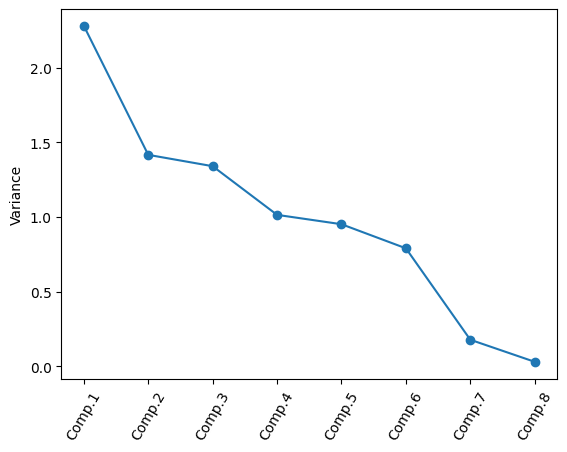

In [27]:
def screeplot(pca, standardised_values):
    y = np.std(pca.transform(standardised_values), axis=0)**2
    x = np.arange(len(y)) + 1
    plt.plot(x, y, "o-")
    plt.xticks(x, ["Comp."+str(i) for i in x], rotation=60)
    plt.ylabel("Variance")
    plt.show()

screeplot(pca, standardisedX)

### Loadings for the Principal Components

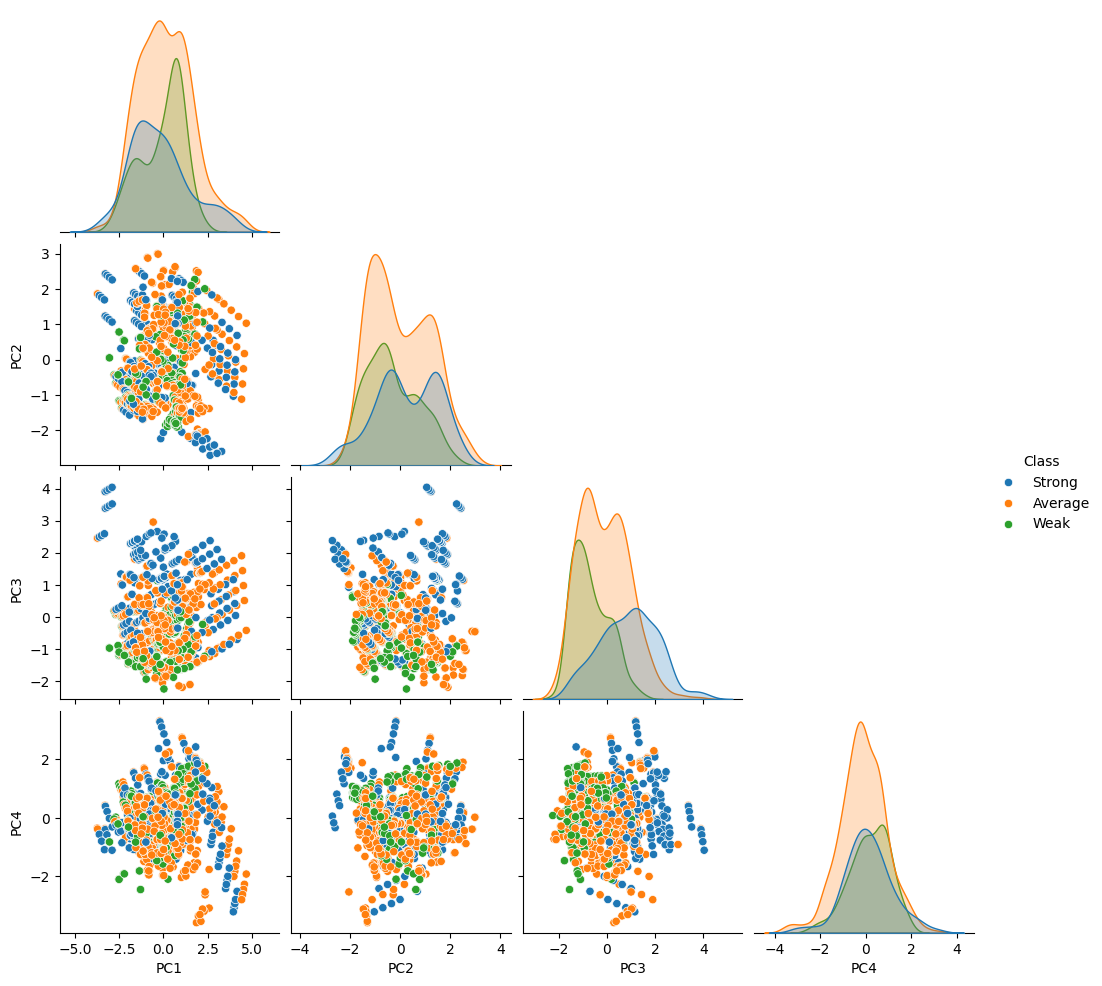

In [28]:
def pca_pairplot(pca, standardised_values, classifs):
    # Transform the standardized data using PCA
    foo = pca.transform(standardised_values)
    
    # Create a DataFrame with the first 4 principal components
    bar = pd.DataFrame({
        "PC1": foo[:, 0],
        "PC2": foo[:, 1],
        "PC3": foo[:, 2],
        "PC4": foo[:, 3],
        "Class": classifs
    })
    
    # Create a pairplot of the first 4 principal components with class as hue
    sns.pairplot(data=bar, vars=["PC1", "PC2", "PC3", "PC4"], hue="Class", diag_kind="kde", corner=True)
    
pca_pairplot(pca, standardisedX, Y_labeled)

#### PC1

In [29]:
pca.components_[0]

array([ 0.09840137,  0.17726197, -0.39466185,  0.54700395, -0.50594541,
        0.03792808, -0.40192597,  0.29147949])

Positive: (cement:0.098), (blast_furnace_slag:0.177), (water:0.547), (coarse_aggregate:0.03792808), (age:0.29147949)

Negative: (fly_ash:-0.394), (superplasticizer:-0.506), (fine_aggregate:-0.4019)

Dominated by **Water** with a strong positive contribution (0.547), indicating that water content significantly influences variance in PC1.
Negative influences from **Superplasticizer**, **Fine Aggregate**, and **Fly Ash**, which reduce the variance in PC1.

#### PC2

In [30]:
pca.components_[1]

array([-0.11373709,  0.6860529 , -0.14294751,  0.05325628,  0.2829296 ,
       -0.62994342, -0.01939111, -0.12598089])

Positive: ('blast_furnace_slag':0.6860529), ('water':0.05325628), (superplasticizer:0.2829296)

Negative: ('cement':-0.11373709), ('fly_ash':-0.14294751),('coarse_aggregate':-0.62994342), ('fine_aggregate':-0.01939111), ('age':-0.12598089)

Strong positive contribution from Blast Furnace Slag (0.686).
Negative contribution from Coarse Aggregate (-0.630), suggesting an inverse relationship in PC2 between these materials.

#### PC3

In [31]:
pca.components_[2]

array([ 0.81420224, -0.17179437, -0.40822055, -0.21318975,  0.23459653,
       -0.17408781, -0.00456921,  0.10052137])

Positive:
('cement':0.81420224), ('superplasticizer':0.23459653), ('age':0.10052137)

Negative:
('blast_furnace_slag':-0.17179437), ('fly_ash':-0.40822055), ('water':-0.21318975), ('coarse_aggregate':-0.17408781), ('fine_aggregate':-0.00456921)

Primarily driven by **Cement** (0.814), indicating cement content is a key descriptor here.
**Fly Ash** plays a counterbalancing role with a negative contribution (-0.408).

#### PC4

In [32]:
pca.components_[3]

array([ 0.054297  ,  0.36269932, -0.2267512 , -0.29606003,  0.03727351,
        0.54580513, -0.38528206, -0.52791909])

Positive:
('cement':0.054297), ('blast_furnace_slag':0.36269932), ('superplasticizer':0.03727351), ('coarse_aggregate':0.54580513)

Negative:
('fly_ash':-0.2267512), ('water':-0.29606003), ('fine_aggregate':-0.38528206), ('age':-0.52791909)

Strong contributions from **Age** (0.528) and **Fine Aggregate** (0.385), with **Coarse Aggregate** having a strong negative influence (-0.546), suggesting a balancing effect between these properties.

In [33]:
printMeanAndSdByGroup(standardisedX, Y_labeled);

## Means:


,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age
Average,-0.072344,-0.000759,0.068315,0.157448,-0.076178,-0.085155,-0.058171,0.084849
Strong,0.689751,0.178351,-0.180722,-0.486653,0.545015,-0.157584,-0.172547,0.355506
Weak,-0.545624,-0.176838,0.044622,0.172978,-0.393250,0.327235,0.288437,-0.524547



## Standard deviations:


,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age
Average,0.935708,1.026321,0.980589,0.997680,0.893080,0.955511,1.025854,1.102344
Strong,0.980753,0.919373,0.921035,1.091784,1.130612,1.103781,1.060052,1.060216
Weak,0.715035,0.998318,1.093613,0.715235,0.819980,0.905575,0.814394,0.201575



## Sample sizes:


,0
Average,514
Strong,258
Weak,258


In [34]:
# Function to create PCA scatter plots for all combinations of PC1-PC4
def pca_scatter_all_combinations(pca, standardised_values, classifs):
    # Perform PCA transformation
    foo = pca.transform(standardised_values)
    # Define the combinations of principal components
    combinations = [("PC1", "PC2"), ("PC1", "PC3"), ("PC1", "PC4"), 
                    ("PC2", "PC3"), ("PC2", "PC4"), ("PC3", "PC4")]
    # Loop through each combination and generate scatter plots
    for x_pc, y_pc in combinations:
        # Extract the corresponding principal components
        pc_x_idx = int(x_pc[2]) - 1  # Adjust to 0-indexing
        pc_y_idx = int(y_pc[2]) - 1
        # Create a dataframe for plotting
        bar = pd.DataFrame(zip(foo[:, pc_x_idx], foo[:, pc_y_idx], classifs), 
                           columns=[x_pc, y_pc, "Class"])
        # Create the scatter plot
        sns.lmplot(data=bar, x=x_pc, y=y_pc, hue="Class", fit_reg=False, legend_out=True)
        # Set the title for the plot
        plt.title(f"{x_pc} vs {y_pc}")
        # Adjust layout to avoid clipping
        # Save the plot to the "figures" directory
        plt.savefig(f"figures/{x_pc}_vs_{y_pc}.png")
        # Close the plot to avoid overwriting in the loop
        plt.close()

# Call the function
pca_scatter_all_combinations(pca, standardisedX, Y_labeled)


/home/oscar/miniconda3/envs/dhenv/lib/python3.10/site-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/home/oscar/miniconda3/envs/dhenv/lib/python3.10/site-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/home/oscar/miniconda3/envs/dhenv/lib/python3.10/site-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/home/oscar/miniconda3/envs/dhenv/lib/python3.10/site-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(ms

## LDA

In [35]:
# Perform LDA on the dataset and categorize based on compressive strength
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Step 3: Perform LDA
lda = LDA(n_components=2)
X_lda = lda.fit_transform(standardisedX, Y_labeled)

# Step 4: Create a dataframe to store the LDA results
lda_df = pd.DataFrame(X_lda, columns=['LD1', 'LD2'])
lda_df['Strength Category'] = Y_labeled

# Step 5: Display the LDA results
display(lda_df)

# Show explained variance ratio
print("Explained variance ratio for LD1 and LD2:", lda.explained_variance_ratio_)



,LD1,LD2,Strength Category
0,-1.761346,-1.103696,Strong
1,-1.789351,-1.221623,Strong
2,-2.377949,2.855034,Average
3,-3.564016,3.504479,Average
4,-2.730036,1.951525,Average
...,...,...,...
1025,-0.473006,0.751277,Average
1026,0.142869,1.405760,Average
1027,0.943463,1.130437,Weak
1028,0.705004,-0.858772,Average


Explained variance ratio for LD1 and LD2: [0.95719738 0.04280262]


In [36]:
standardisedX

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age
0,2.477915,-0.856888,-0.847144,-0.916764,-0.620448,0.863154,-1.217670,-0.279733
1,2.477915,-0.856888,-0.847144,-0.916764,-0.620448,1.056164,-1.217670,-0.279733
2,0.491425,0.795526,-0.847144,2.175461,-1.039143,-0.526517,-2.240917,3.553066
3,0.491425,0.795526,-0.847144,2.175461,-1.039143,-0.526517,-2.240917,5.057677
4,-0.790459,0.678408,-0.847144,0.488793,-1.039143,0.070527,0.647884,4.978487
...,...,...,...,...,...,...,...,...
1025,-0.045645,0.488235,0.564545,-0.092171,0.451410,-1.323005,-0.065893,-0.279733
1026,0.392819,-0.856888,0.960068,0.676200,0.702626,-1.994680,0.496893,-0.279733
1027,-1.270088,0.759579,0.850635,0.521589,-0.017528,-1.036064,0.080107,-0.279733
1028,-1.168610,1.308065,-0.847144,-0.279579,0.853356,0.214641,0.191166,-0.279733


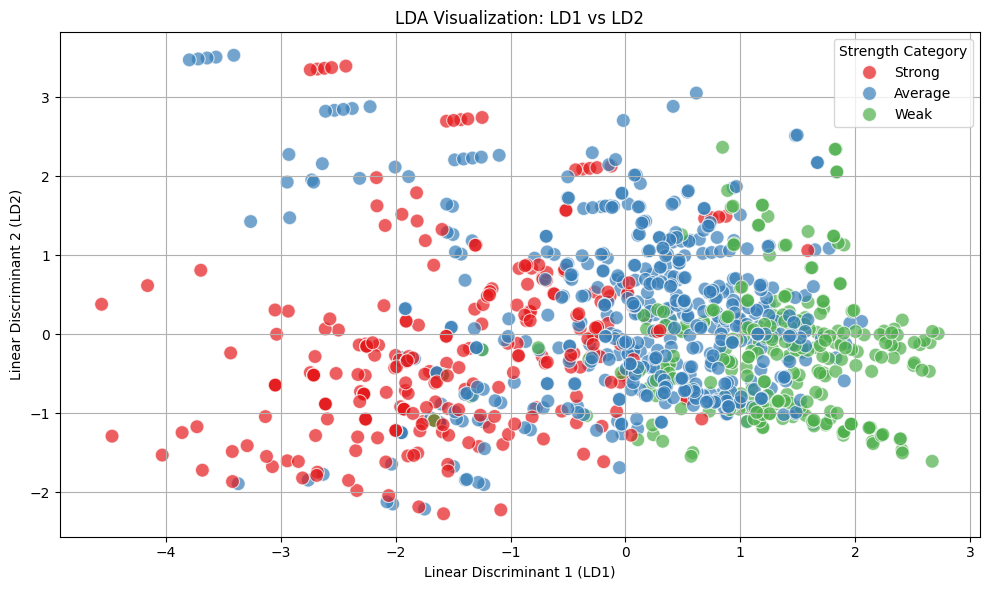

In [37]:
# Plot LDA components
plt.figure(figsize=(10, 6))
sns.scatterplot(data=lda_df, x='LD1', y='LD2', hue='Strength Category', palette='Set1', s=100, alpha=0.7)
plt.title('LDA Visualization: LD1 vs LD2')
plt.xlabel('Linear Discriminant 1 (LD1)')
plt.ylabel('Linear Discriminant 2 (LD2)')
plt.legend(title='Strength Category')
plt.grid(True)
plt.tight_layout()
# Save the figure to the figures directory
plt.savefig('figures/LDA_Visualization.png')

# Show the plot
plt.show()

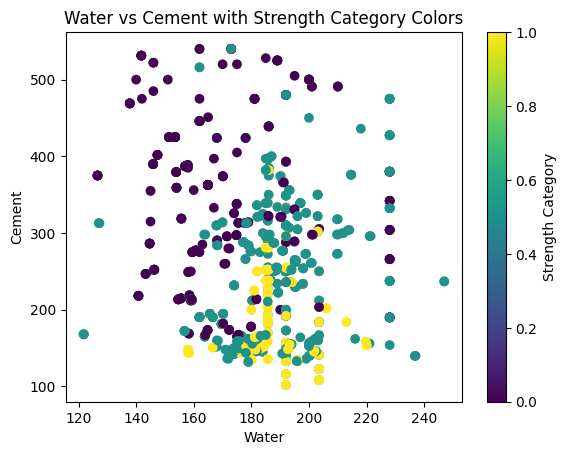

In [38]:
class_str = lda_df['Strength Category']

# Assuming ligma is categorical, let's map the categories to color values
unique_categories = class_str.unique()
colors = np.linspace(0, 1, len(unique_categories))  # Generate colors for categories
color_map = dict(zip(unique_categories, colors))    # Map each category to a color

# Convert the categories in ligma to corresponding colors
category_colors = class_str.map(color_map)

# Use plt.scatter for a proper color map based on the categorical values
plt.scatter(X['water'], X['cement'], c=category_colors, cmap='viridis')

plt.colorbar(label='Strength Category')  # Optional: to display a color bar
plt.xlabel('Water')
plt.ylabel('Cement')
plt.title('Water vs Cement with Strength Category Colors')
plt.savefig(f"figures/LDA_water_vs_Cement.png")
plt.show()

#https://www.geeksforgeeks.org/k-means-clustering-introduction/

Based on the provided **LDA visualization** and **PCA scatter plots**, here are the conclusions that can be drawn regarding the influence of material properties on concrete compressive strength and their separability:

### 1. **LDA Analysis (LD1 vs. LD2 Plot)**
- **Class Separation**: 
  - The LDA visualization shows clear grouping, particularly with the "Weak" and "Strong" categories being somewhat distinguishable. This indicates that **Linear Discriminant Analysis** was effective in finding a projection of the features that separates the categories.
  - **Strong** compressive strength points (red) are mostly separated from the **Weak** compressive strength points (green), indicating that different combinations of features effectively separate these classes.
  - However, there is significant overlap with the **Average** compressive strength category (blue), which suggests that the boundary between "Average" and other strengths is less distinct.

- **Explanation**: The LDA is focused on maximizing the separation between classes, and the high variance explained by LD1 indicates that this direction is highly effective in capturing the differences. This means that specific combinations of features contribute significantly to defining whether concrete strength is "Weak," "Average," or "Strong."

### 2. **PCA Scatter Plots Analysis**
- The **PCA scatter plots** between **PC1, PC2, PC3, and PC4** reveal the relationships between principal components and the concrete strength categories.

- **PC1 vs. PC2**:
  - The classes overlap significantly in this space, which indicates that the linear combination of features represented by **PC1** and **PC2** does not fully distinguish between "Weak," "Average," and "Strong" categories.
  - There is some clustering visible, but the separation is not as clear as in LDA, meaning that PCA, which focuses on variance rather than class separability, is less effective for distinguishing compressive strength classes.

- **PC1 vs. PC3** and **PC1 vs. PC4**:
  - The overlap between "Average" and "Weak" classes continues in these scatter plots, indicating that these principal components do not provide sufficient separation.
  - **PC3** and **PC4** capture additional variance that might not be directly related to class separability, but rather the overall spread of material features.

- **PC2 vs. PC3, PC2 vs. PC4, and PC3 vs. PC4**:
  - In these scatter plots, the classes show significant mixing, suggesting that the lower principal components do not provide much class separation.
  - The **variance explained** by these components is lower compared to PC1, meaning that their influence on the variation in material properties is less significant when it comes to classifying the compressive strength.

### **Key Factors Influencing Concrete Compressive Strength**:
From the **PCA** and **LDA** analysis, we can draw some conclusions about the **key factors that influence concrete compressive strength**:

1. **Water-Cement Ratio**:
   - **Water** and **Cement** are likely key contributors since they are major determinants of the hydration process, which is critical for concrete strength development.
   - Lower **water-cement ratios** tend to result in higher strength, as less water leads to fewer voids in the concrete mix.

2. **Cement Content**:
   - The **amount of cement** in the mixture significantly influences strength. More cement results in a stronger mix due to the increased availability of hydrated compounds.

3. **Aggregate Properties**:
   - **Coarse Aggregate** and **Fine Aggregate** also play an important role. Their proper grading ensures fewer voids and more compact packing, leading to stronger concrete.
   - The type, size, and proportion of aggregates may impact the PCA, explaining some of the spread in PC3 and PC4.

4. **Admixtures**:
   - The presence of **superplasticizers** and other admixtures affects the workability of the mix, allowing for a lower water-cement ratio while still maintaining workability, which indirectly leads to increased strength.

5. **Age**:
   - **Age** of the concrete is another critical factor. The curing process allows the concrete to continue to gain strength over time as more of the cement hydrates.

### **Summary of Findings**:
- The **LDA visualization** indicates that we can distinguish "Strong" from "Weak" categories quite effectively, but distinguishing "Average" from the other two classes is more challenging.
- **Principal Component Analysis** shows that a few key components (like **PC1**) capture significant variance but do not necessarily provide distinct boundaries for compressive strength classes.
- The **separation** achieved in the LDA plot suggests that combinations of certain features, likely **cement content, water content, aggregates,** and **age**, are crucial for determining whether a concrete sample is classified as "Weak," "Average," or "Strong."

For future improvements, further feature engineering, such as deriving the **water-cement ratio** explicitly or including other properties like **curing conditions**, might help achieve better class separability.